##Required imports

In [1]:
!pip install einops


In [2]:
!pip install -q open_clip_torch
import open_clip

c:\Users\user\Desktop\Cross-HL-main\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

import sys, os
sys.path.append(os.getcwd())

import sys
sys.path.append("./../")
import os
import numpy as np
import random
from torch import einsum
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.utils.data as dataf
from torch.utils.data import Dataset
from scipy import io
from scipy.io import loadmat as loadmat
from sklearn.decomposition import PCA
from torch.nn.parameter import Parameter
import torchvision.transforms.functional as TF
from torch.nn import LayerNorm,Linear,Dropout,Softmax
import time
from PIL import Image
import math
from operator import truediv
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from torchsummary import summary
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn
import re
from pathlib import Path
import copy
import open_clip

import utils
import logger

cudnn.deterministic = True
cudnn.benchmark = False

# Dataset

In [4]:
class HSI_LiDAR_DatasetTrain(torch.utils.data.Dataset):
    def __init__(self, dataset='Trento'):

        HSI = loadmat(f'./{dataset}11x11/HSI_Tr.mat')
        LiDAR = loadmat(f'./{dataset}11x11/LIDAR_Tr.mat')
        label = loadmat(f'./{dataset}11x11/TrLabel.mat')

        self.hs_image = (torch.from_numpy(HSI['Data'].astype(np.float32)).to(torch.float32)).permute(0,3,1,2)
        self.lidar_image = (torch.from_numpy(LiDAR['Data'].astype(np.float32)).to(torch.float32)).permute(0,3,1,2)
        self.lbls = ((torch.from_numpy(label['Data'])-1).long()).reshape(-1)

    def __len__(self):
        return self.hs_image.shape[0]

    def __getitem__(self, i):
        return self.hs_image[i], self.lidar_image[i], self.lbls[i]

class HSI_LiDAR_DatasetTest(torch.utils.data.Dataset):
    def __init__(self, dataset='Trento'):

        HSI = loadmat(f'./{dataset}11x11/HSI_Te.mat')
        LiDAR = loadmat(f'./{dataset}11x11/LIDAR_Te.mat')
        label = loadmat(f'./{dataset}11x11/TeLabel.mat')

        self.hs_image = (torch.from_numpy(HSI['Data'].astype(np.float32)).to(torch.float32)).permute(0,3,1,2)
        self.lidar_image = (torch.from_numpy(LiDAR['Data'].astype(np.float32)).to(torch.float32)).permute(0,3,1,2)
        self.lbls = ((torch.from_numpy(label['Data'])-1).long()).reshape(-1)


    def __len__(self):
        return self.hs_image.shape[0]

    def __getitem__(self, i):
        return self.hs_image[i], self.lidar_image[i], self.lbls[i]

# Cross-HL Model

In [ ]:
class HetConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1,padding = None, bias = None,p = 64, g = 64):
        super(HetConv, self).__init__()
        # Groupwise Convolution
        self.groupwise_conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,groups=g,padding = kernel_size//3, stride = stride)
        # Pointwise Convolution
        self.pointwise_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1,groups=p, stride = stride)
    def forward(self, x):
        return self.groupwise_conv(x) + self.pointwise_conv(x)



# Cross-HL Attention Module
class CrossHL_attention(nn.Module):
    def __init__(self, dim, patches, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0.1, proj_drop=0.1):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5
        self.dim = dim
        self.Wq = nn.Linear(patches, dim * num_heads , bias=qkv_bias)
        self.Wk = nn.Linear(dim, dim , bias=qkv_bias)
        self.Wv = nn.Linear(patches+1, dim , bias=qkv_bias)
        self.linear_projection = nn.Linear(dim * num_heads, dim)
        self.linear_projection_drop = nn.Dropout(proj_drop)

    def forward(self, x, x2):

        B, N, C = x.shape
        # query vector using lidar data
        query = self.Wq(x2).reshape(B, self.num_heads, self.num_heads, self.dim // self.num_heads).permute(0, 1, 2, 3)

        key = self.Wk(x).reshape(B, N, self.num_heads, self.dim // self.num_heads).permute(0, 2, 1, 3)
        value = self.Wv(x.transpose(1,2)).reshape(B, C, self.num_heads, self.dim // self.num_heads).permute(0, 2, 3, 1)
        attention = torch.einsum('bhid,bhjd->bhij', key, query) * self.scale
        attention = attention.softmax(dim=-1)

        x = torch.einsum('bhij,bhjd->bhid', attention, value)
        x = x.reshape(B, N, -1)
        x = self.linear_projection(x)
        x = self.linear_projection_drop(x)
        return x

class MultiLayerPerceptron(nn.Module):
  def __init__(self, dim, mlp_dim):
        super().__init__()
        self.fclayer1 = Linear(dim, mlp_dim)
        self.fclayer2 = Linear(mlp_dim, dim)
        self.act_fn = nn.GELU()
        self.dropout = Dropout(0.1)
        self._init_weights()

  def _init_weights(self):

      nn.init.xavier_uniform_(self.fclayer1.weight)
      nn.init.xavier_uniform_(self.fclayer2.weight)

      nn.init.normal_(self.fclayer1.bias, std=1e-6)
      nn.init.normal_(self.fclayer2.bias, std=1e-6)

  def forward(self, x):
      x = self.fclayer1(x)
      x = self.act_fn(x)
      x = self.dropout(x)
      x = self.fclayer2(x)
      x = self.dropout(x)
      return x


# Code for Single Encoder block contains both cross-hl attention and mlp layer
class SingleEncoderBlock(nn.Module):
    def __init__(self,dim, num_heads, mlp_dim):
        super().__init__()
        self.attention_norm = LayerNorm(dim, eps=1e-6) # First LayerNorm layer
        self.ffn_norm = LayerNorm(dim, eps=1e-6) # Second LayerNorm layer

        self.ffn = MultiLayerPerceptron(dim, mlp_dim) # MLP layer
        self.cross_hl_attention = CrossHL_attention(dim = dim, patches = 11**2) # Cross-HL Attention layer
    def forward(self, x1,x2):
        res = x1
        x = self.attention_norm(x1)
        x= self.cross_hl_attention(x,x2)
        x = x + res
        res = x
        x = self.ffn_norm(x)
        x = self.ffn(x)
        x = x + res
        return x

# Code for Multiple Encoder blocks
class Encoder(nn.Module):

    def __init__(self, dim, num_heads=8, mlp_dim=512, depth=2):
        super().__init__()
        self.layer = nn.ModuleList()
        self.encoder_norm = LayerNorm(dim, eps=1e-6)
        for _ in range(depth):
            layer = SingleEncoderBlock(dim, num_heads, mlp_dim)
            self.layer.append(copy.deepcopy(layer))

    def forward(self, x,x2):
        for layer_block in self.layer:
            x = layer_block(x,x2)
        encoded = self.encoder_norm(x)


        return encoded[:,0] # Selecting only the first row of each batch since it is the cls token


class CrossHL_Transformer(nn.Module):
    def __init__(self, FM, NC, NCLidar, Classes,patchsize):
        super(CrossHL_Transformer, self).__init__()
        self.patchsize = patchsize
        self.NCLidar = NCLidar
        self.conv5 = nn.Sequential(
            nn.Conv3d(1, 8, (9, 3, 3), padding=(0,1,1), stride = 1),
            nn.BatchNorm3d(8),
            nn.ReLU()
        )

        self.hetconv_layer = nn.Sequential(
            HetConv(8 * (NC - 8), FM*4,
                p = 1,
                g = (FM*4)//4 if (8 * (NC - 8))%FM == 0 else (FM*4)//8,
                   ),
            nn.BatchNorm2d(FM*4),
            nn.ReLU()
        )

        self.ca = Encoder(FM*4)
        self.fclayer = nn.Linear(FM*4 , Classes)
        self.vlm_dim = 512
        self.vlm_proj = nn.Linear(FM*4, self.vlm_dim)  #vlm projection layer

        self.position_embeddings = nn.Parameter(torch.randn(1, (patchsize**2) + 1, FM*4))
        self.dropout = nn.Dropout(0.1)
        torch.nn.init.xavier_uniform_(self.fclayer.weight)
        torch.nn.init.normal_(self.fclayer.bias, std=1e-6)
        # randomly initialized cls token
        self.clsTok = nn.Parameter(torch.zeros(1, 1, FM*4))


    def forward(self, x1, x2, return_embed=False):
        x1 = x1.reshape(x1.shape[0],-1,self.patchsize,self.patchsize)
        x2 = x2.reshape(x1.shape[0],-1,self.patchsize*self.patchsize)
        x1 = x1.unsqueeze(1)
        if(x2.shape[1] > 0):
            x2 = F.adaptive_avg_pool1d(x2.flatten(2).transpose(1,2),1).transpose(1,2).reshape(x1.shape[0],-1,self.patchsize*self.patchsize)
        x1 = self.conv5(x1)
        x1 = x1.reshape(x1.shape[0],-1,self.patchsize,self.patchsize)

        x1 = self.hetconv_layer(x1)
        x1 = x1.flatten(2)

        x1 = x1.transpose(-1, -2)
        cls_tokens = self.clsTok.expand(x1.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x1), dim = 1)
        x = x + self.position_embeddings
        x = self.dropout(x)

        cls = self.ca(x, x2)                 # [B, FM*4]
        logits = self.fclayer(cls)           # [B, Classes]

        if return_embed:
            img_embed = F.normalize(self.vlm_proj(cls), dim=-1)  # [B, 512] #Into CLS token projection 
            return logits, img_embed
        return logits


## Model Summary (for Trento Dataset)

In [6]:
model = CrossHL_Transformer(FM=16, NC=63, NCLidar=1, Classes=6,patchsize = 11)
summary(model, [(63, 11**2),(1,11**2)]) # summary(model, [(NC, patchsize**2),(NCLidar,patchsize**2)])
print(hasattr(model, "vlm_proj"), model.vlm_proj if hasattr(model,"vlm_proj") else None)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1        [-1, 8, 55, 11, 11]             656
       BatchNorm3d-2        [-1, 8, 55, 11, 11]              16
              ReLU-3        [-1, 8, 55, 11, 11]               0
            Conv2d-4           [-1, 64, 11, 11]          31,744
            Conv2d-5           [-1, 64, 11, 11]          28,224
           HetConv-6           [-1, 64, 11, 11]               0
       BatchNorm2d-7           [-1, 64, 11, 11]             128
              ReLU-8           [-1, 64, 11, 11]               0
           Dropout-9              [-1, 122, 64]               0
        LayerNorm-10              [-1, 122, 64]             128
           Linear-11               [-1, 1, 512]          61,952
           Linear-12              [-1, 122, 64]           4,096
           Linear-13               [-1, 64, 64]           7,808
           Linear-14              [-1, 

# Model Training

---------------------------------- Details for Trento dataset---------------------------------------------


Train samples: 819, Test samples: 29395, HS bands: 63, LiDAR channels: 1, Classes: 6


---------------------------------- Summary ---------------------------------------------


Using device: cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1        [-1, 8, 55, 11, 11]             656
       BatchNorm3d-2        [-1, 8, 55, 11, 11]              16
              ReLU-3        [-1, 8, 55, 11, 11]               0
            Conv2d-4           [-1, 64, 11, 11]          31,744
            Conv2d-5           [-1, 64, 11, 11]          28,224
           HetConv-6           [-1, 64, 11, 11]               0
       BatchNorm2d-7           [-1, 64, 11, 11]             128
              ReLU-8           [-1, 64, 11, 11]               0
           Dropout-9              [-1, 122, 64]       

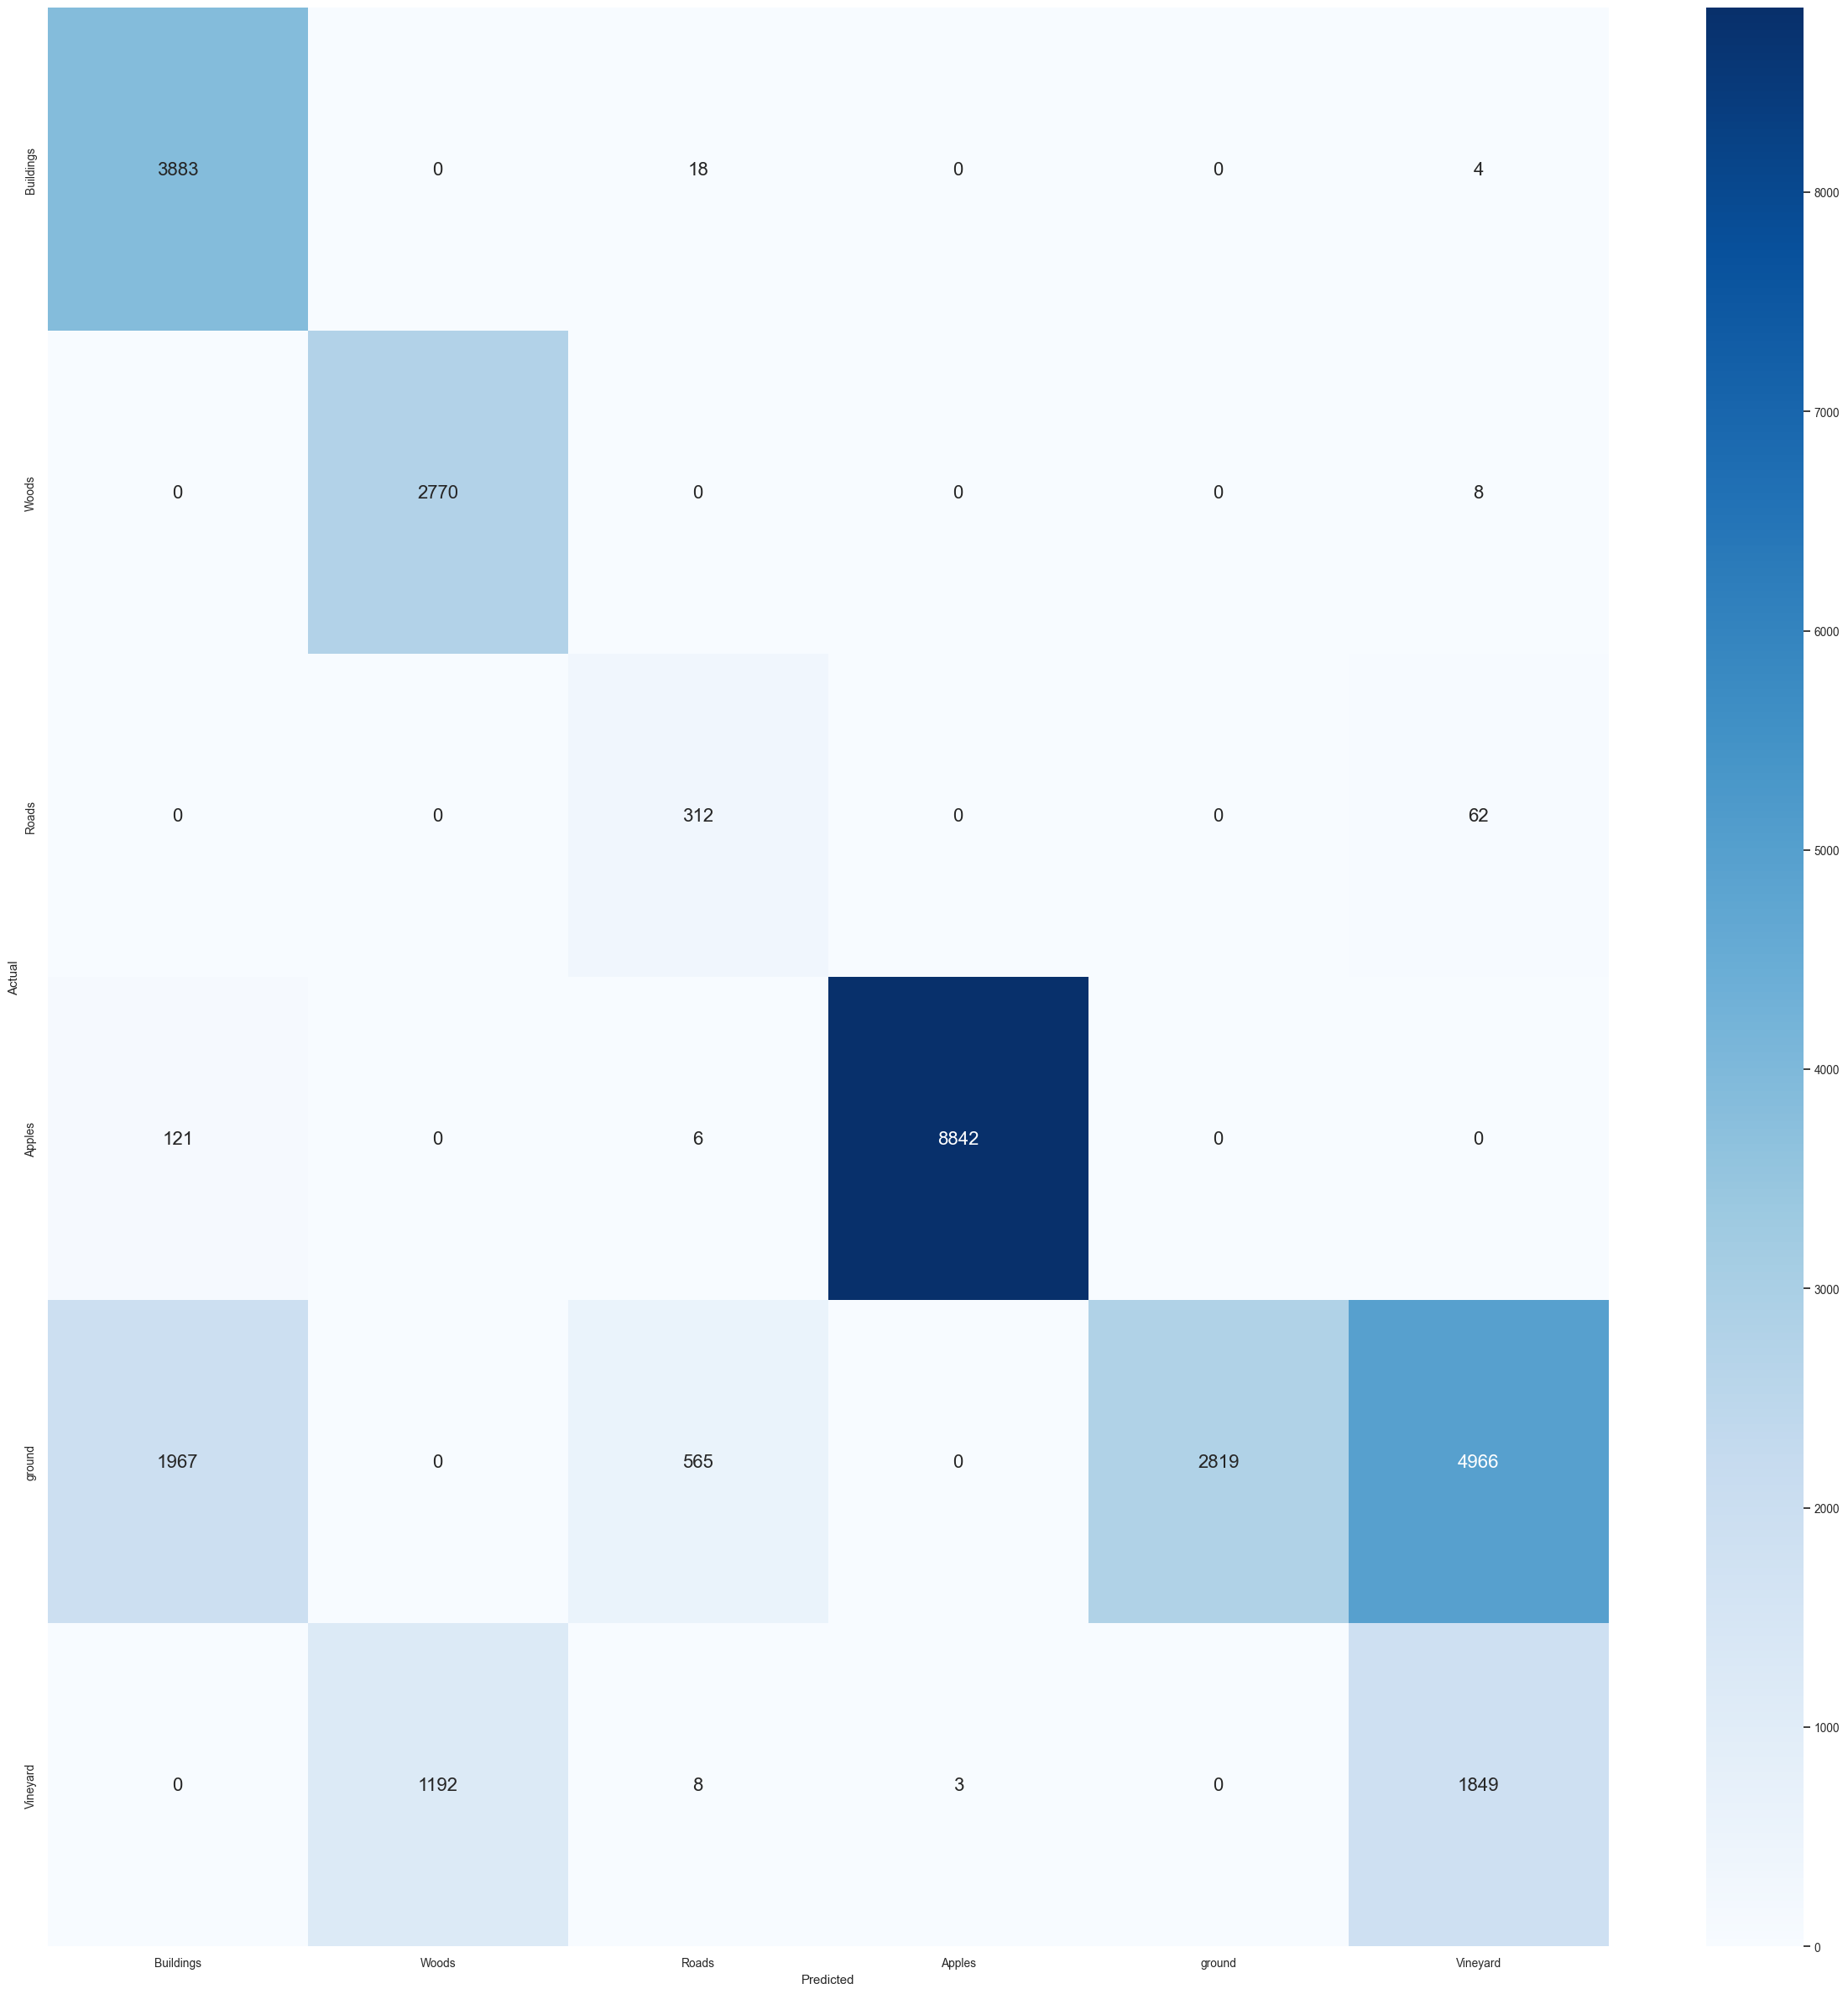

In [ ]:
#os.environ["CUDA_VISIBLE_DEVICES"]="0"
datasetNames = ["Trento"] # ["Trento", "MUUFL", "Houston"]
MultiModalData = 'LiDAR'
modelName = 'Cross-HL'

patchsize = 11
batch_size = 64 # batch size for training
test_batch_size = 500
EPOCHS = 5
learning_rate = 5e-4
FM = 16
FileName = 'CrossHL'
num_heads = 8 # d_h = number of mhsa heads
mlp_dim = 512
depth = 2 # Number of transformer encoder layer
num_iterations = 1
train_loss = []

def seed_val(seed=14):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)


for dataset in datasetNames:
        print(f"---------------------------------- Details for {dataset} dataset---------------------------------------------")
        print('\n')
        try:
            os.makedirs(dataset)
        except FileExistsError:
            pass

        train_dataset = HSI_LiDAR_DatasetTrain(dataset=dataset)
        test_dataset = HSI_LiDAR_DatasetTest(dataset=dataset)
        # print(len(train_dataset),len(test_dataset))
        NC = train_dataset.hs_image.shape[1]

        NCLidar = train_dataset.lidar_image.shape[1]
        Classes = len(torch.unique(train_dataset.lbls))
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        

                # ---- CLIP text embeddings (semantic prior) ----
        clip_model, _, _ = open_clip.create_model_and_transforms(
            "ViT-B-32",
            pretrained="laion2b_s34b_b79k"
        )
        tokenizer = open_clip.get_tokenizer("ViT-B-32")
        clip_model = clip_model.to(device).eval()

        # class names 
        class_names = ["Buildings", "Woods", "Roads", "Apples", "ground", "Vineyard"]
        assert len(class_names) == Classes, "class_names count must match Classes!"

        prompts = [f"a remote sensing patch of {c}" for c in class_names]

        with torch.no_grad():
            text_tokens = tokenizer(prompts).to(device)
            text_embeds = clip_model.encode_text(text_tokens)
            text_embeds = F.normalize(text_embeds, dim=-1)   # [Classes, 512]


        train_loader = dataf.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers= 0)


        test_patch_hsi = test_dataset.hs_image
        test_patch_lidar = test_dataset.lidar_image
        test_label = test_dataset.lbls

        KAPPA = []
        OA = []
        AA = []
        ELEMENT_ACC = np.zeros((num_iterations, Classes)) # num_iterationsxNC

        seed_val(14)
        for iterNum in range(num_iterations):
            
            print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}, "f"HS bands: {NC}, LiDAR channels: {NCLidar}, Classes: {Classes}")

            print('\n')
            print("---------------------------------- Summary ---------------------------------------------")
            print('\n')
            #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            print("Using device:", device)

            model = CrossHL_Transformer(FM=FM, NC=NC, NCLidar=NCLidar, Classes=Classes, patchsize=patchsize).to(device)

            summary(model, [(NC, patchsize**2),(NCLidar,patchsize**2)])

            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=5e-3)
            loss_func = nn.CrossEntropyLoss()  # the target label is not one-hotted
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.9)
            BestAcc = 0
            if torch.cuda.is_available():
                torch.cuda.synchronize()




            print('\n')
            print(f"---------------------------------- Training started for {dataset} dataset ---------------------------------------------")
            print('\n')
            start = time.time()
            # train and test the proposed model
            for epoch in range(EPOCHS):
                for step, (batch_hsi, batch_ldr, batch_lbl) in enumerate(train_loader):
                    # print(f"Step:{step} batch_hsi shape :{batch_hsi.shape} batch_ldr shape : {batch_ldr.shape} batch_lbl shape: {batch_lbl.shape}")
                    batch_hsi = batch_hsi.to(device)
                    batch_ldr = batch_ldr.to(device)
                    batch_lbl = batch_lbl.to(device)
                    logits, img_embed = model(batch_hsi, batch_ldr, return_embed=True)

                    loss_ce = loss_func(logits, batch_lbl)

                    logits_clip = img_embed @ text_embeds.T  # [B, Classes]
                    loss_clip = loss_func(logits_clip, batch_lbl)

                    lambda_clip = 0.3  # try 0.1~0.5
                    loss = loss_ce + lambda_clip * loss_clip

                    optimizer.zero_grad()  # Clearing gradients
                    loss.backward()
                    optimizer.step()

                    if step % 200 == 0:
                        model.eval()
                        y_pred = np.empty((len(test_label)), dtype='float32')
                        number = len(test_label) // test_batch_size
                        for i in range(number):
                            temp = test_patch_hsi[i * test_batch_size:(i + 1) * test_batch_size, :, :]
                            temp = temp.to(device)
                            temp1 = test_patch_lidar[i * test_batch_size:(i + 1) * test_batch_size, :, :]
                            temp1 = temp1.to(device)
                            temp2 = model(temp, temp1)
                            temp3 = torch.max(temp2, 1)[1].squeeze()
                            y_pred[i * test_batch_size:(i + 1) * test_batch_size] = temp3.cpu()
                            del temp, temp1, temp2, temp3

                        if (i + 1) * test_batch_size < len(test_label):
                            temp = test_patch_hsi[(i + 1) * test_batch_size:len(test_label), :, :]
                            temp = temp.to(device)
                            temp1 = test_patch_lidar[(i + 1) * test_batch_size:len(test_label), :, :]
                            temp1 = temp1.to(device)
                            temp2 = model(temp, temp1)
                            temp3 = torch.max(temp2, 1)[1].squeeze()
                            y_pred[(i + 1) * test_batch_size:len(test_label)] = temp3.cpu()
                            del temp, temp1, temp2, temp3

                        y_pred = torch.from_numpy(y_pred).long()
                        accuracy = torch.sum(y_pred == test_label).type(torch.FloatTensor) / test_label.size(0)

                        print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.cpu().numpy(), '| test accuracy: %.4f' % (accuracy*100))
                        train_loss.append(loss.data.cpu().numpy())

                        if accuracy > BestAcc:

                            BestAcc = accuracy

                            torch.save(model.state_dict(), dataset+'/net_params_'+FileName+'.pkl')


                        model.train()
                scheduler.step()
            if torch.cuda.is_available():
                torch.cuda.synchronize()

            end = time.time()
            print('\nThe train time (in seconds) is:', end - start)
            Train_time = end - start


            state_dict = torch.load(dataset + '/net_params_' + FileName + '.pkl', map_location='cpu')
            model.load_state_dict(state_dict)
            model.to(device)  # device is cpu 

            model.eval()

            confusion_mat, overall_acc, class_acc, avg_acc, kappa_score = utils.result_reports(test_patch_hsi, test_patch_lidar, test_label, dataset, model, iterNum)
            KAPPA.append(kappa_score)
            OA.append(overall_acc)
            AA.append(avg_acc)
            ELEMENT_ACC[iterNum, :] = class_acc
            torch.save(model, dataset+'/best_model_'+FileName+'_Iter'+str(iterNum)+'.pt')
            
            # --- Evaluate CLIP semantic head accuracy ---
            with torch.no_grad():
                y_pred_clip = np.empty((len(test_label)), dtype='float32')
                number = len(test_label) // test_batch_size

                for i in range(number):
                    temp = test_patch_hsi[i*test_batch_size:(i+1)*test_batch_size].to(device)
                    temp1 = test_patch_lidar[i*test_batch_size:(i+1)*test_batch_size].to(device)

                    _, img_embed = model(temp, temp1, return_embed=True)
                    logits_clip = img_embed @ text_embeds.T
                    pred = torch.argmax(logits_clip, dim=1).cpu().numpy()

                    y_pred_clip[i*test_batch_size:(i+1)*test_batch_size] = pred

                if (i+1)*test_batch_size < len(test_label):
                    temp = test_patch_hsi[(i+1)*test_batch_size:].to(device)
                    temp1 = test_patch_lidar[(i+1)*test_batch_size:].to(device)

                    _, img_embed = model(temp, temp1, return_embed=True)
                    logits_clip = img_embed @ text_embeds.T
                    pred = torch.argmax(logits_clip, dim=1).cpu().numpy()

                    y_pred_clip[(i+1)*test_batch_size:] = pred

                y_pred_clip = torch.from_numpy(y_pred_clip).long()
                acc_clip = (y_pred_clip == test_label).float().mean().item() * 100

            print('\n')
            print(f"CLIP-head test accuracy (semantic): {acc_clip:.2f}%")
            print('\n')
            print("Overall Accuracy = ", overall_acc)
            print('\n')
        print(f"---------- Training Finished for {dataset} dataset -----------")
        print("\nThe Confusion Matrix")
        logger.log_result(OA, AA, KAPPA, ELEMENT_ACC,'./' + dataset +'/'+FileName+'_Report_' + dataset +'.txt')